In [76]:
from pydub import AudioSegment
noise_t_audio = AudioSegment.from_file('laptop_mic_t.wav')
noise_p_audio = AudioSegment.from_file('laptop_mic_p.wav')

# get some basic properties
frame_rate = noise_t_audio.frame_rate
print("Frame rate:", frame_rate)
# print(noise_t_audio.duration_seconds)
# print(noise_t_audio.duration_seconds * noise_t_audio.frame_rate == noise_t_audio.frame_count())
# print(noise_t_audio.sample_width)
# print(noise_t_audio.channels)

# convert to mono, so each frame has only one sample
noise_t_audio_mono = noise_t_audio.set_channels(1)
noise_p_audio_mono = noise_p_audio.set_channels(1)

# finally, convert to a more workable data type
import pandas as pd
noise_t = pd.Series(noise_t_audio_mono.get_array_of_samples())
noise_p = pd.Series(noise_p_audio_mono.get_array_of_samples())

Frame rate: 44100


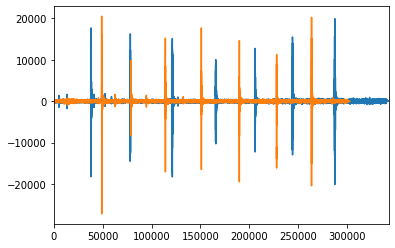

In [77]:
noise_t.plot()
noise_p.plot()